# OpenStreetMap Project
## Udacity Data Analyst Nanodegree Project 3: Data Wrangling with MongoDB

Florina Georgescu - Airbus Operations SL

Github: https://github.com/inageorgescu
                                                
Map Area: Málaga, Spain

https://www.openstreetmap.org/relation/340746

http://www.malaga.eu/

<body> I will analize Málaga and 3 nearby cities( Rincon de la Victoria, Alhaurin de la Torre and Torremolinos) that are located in the Province of Málaga. This is the place where I got married and I usually visit in summer time. I will use data wrangling techniques and querry the data base with MongoDB.
The data has been downloaded with Mapzen.
<body>

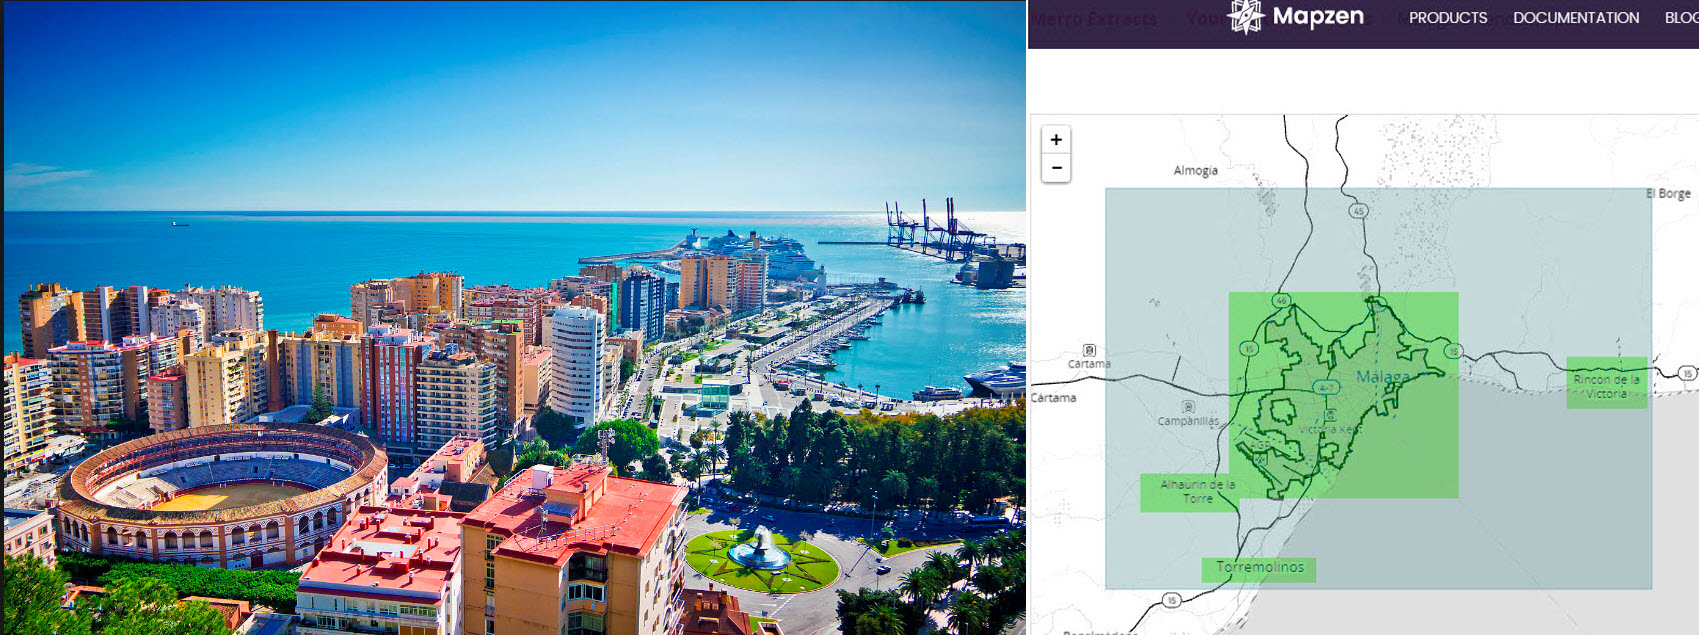

In [4]:
from IPython.display import Image
Image("Malaga_map.jpg")


<body> In order to complete the project the following steps shown in the diagram below must be followed <body> 

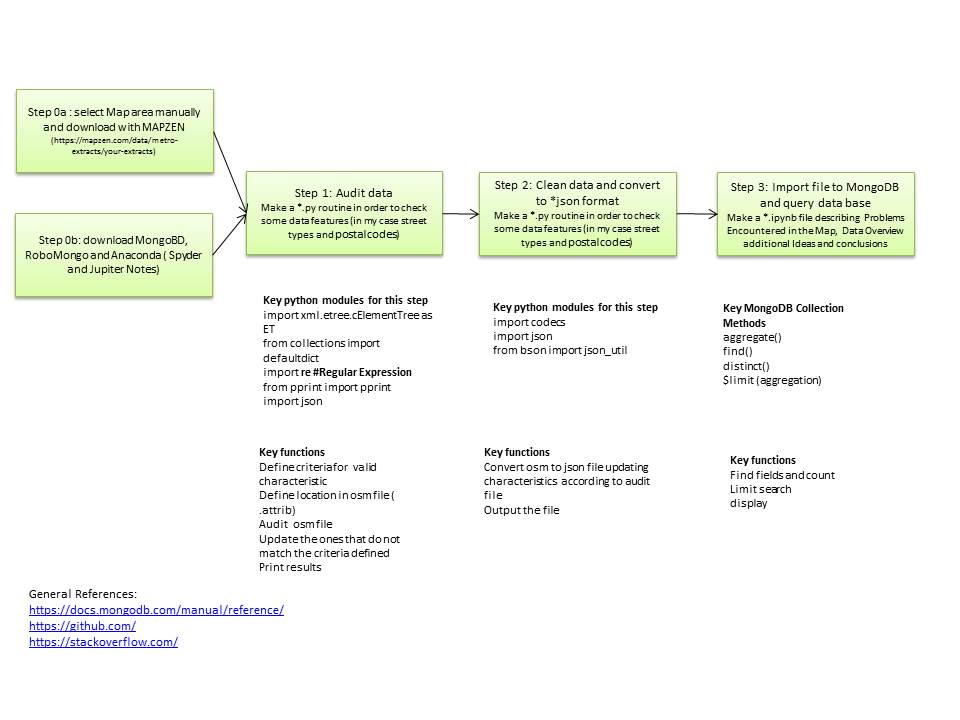

In [5]:
Image("workflow.jpg")

In [6]:
#Import all necesary modules as follows:
#import flexible container object, designed to store hierarchical data structures in memory
import xml.etree.cElementTree as ET
#import function to supply missing values
from collections import defaultdict
#import Regular expression operations
import re
#import “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter
import pprint
#import Codec registry and base classes
import codecs
#import JSON encoder and decoder
import json
import pymongo
import os


In [7]:
#Create a sample file in order to perform the tests and be able to visualize easily

OSM_FILE = "Malaga.osm"  # OSM file for Malaga
SAMPLE_FILE = "sample.osm"

k = 10 # Parameter: take every k-th top level element

def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag

    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


with open(SAMPLE_FILE, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write('</osm>')


## 1. Audit data
The data that I will audit is a OSM file for a given map, in this case Málaga. 
OSM XML is list of instances of data (nodes, ways, and relations) that represent points on the map. Ways contain node references to form either a polyline or polygon on the map. Nodes and ways both contain children tag elements that represent key value pairs of descriptive information about a given node or way.
    
### Problems Encountered in the Map
After using the a sample file of the Malaga area and running it against a provisional audit_atributes.py file, I noticed three main problems with the data, which I will tackle:
#### 1.1. Street type
In Europe the street type is written after the name of the street and must have a standard naming. It is common to use abreviation for it therefore you can have same street type called different ways e.g. "Avenida" can be founf as "AV". "AVDA" etc.
This problem was programmatically solved by function update_names() before creating the database.

#### 1.2. Street without a type of street
There are streets without a street type. This probelm can be solved only if you have a list with street names and their type. It is not our case therefore I will only list ( with the function audit()) the streets that meet this condition in order to identify that there is a problem in the map.

#### 1.3 Postal codes
There are some postal codes that might have not been corectly introduced because they do not belong to the valid postal codes in the area or they are wornlgly introduced.
This problem was programmatically solved by function update_postal_codes() before creating the database.

In [8]:
#Parse file and count number of unique element types
def count_tags(filename):
        tags = {}
        for event, elem in ET.iterparse(filename):
            if elem.tag in tags: 
                tags[elem.tag] += 1
            else:
                tags[elem.tag] = 1
        return tags
view_tags = count_tags(OSM_FILE)
# pprint.pprint(view_tags)

In [9]:
from IPython.display import display
from audit_atributes import audit, update_names, audit_pc, update_postal_codes

OSM_FILE ='./Malaga.osm'
CREATED = [ "version", "changeset", "timestamp", "user", "uid"]
street_types = audit(OSM_FILE)
# display(street_types)

In [31]:
#Update street type
updates = update_names(OSM_FILE)
# display(updates)

In [11]:
updates_pc = update_postal_codes(OSM_FILE)
# display(updates_pc)

## 2. Data Overview with MongoDB

In [12]:
import os
print "The downloaded OSM file is {} MB".format(os.path.getsize('Malaga.osm')/1.0e6) # convert from bytes to megabytes

The downloaded OSM file is 73.625084 MB


In [13]:
from pymongo import MongoClient

db_name = 'openstreetmap1'

# Connect to Mongo DB
client = MongoClient('localhost:27017')
# Database 'openstreetmap' will be created
db = client[db_name]
collection = db['Malaga']


There is a code for running directly from python the mongoimport ( see https://github.com/bestkao/data-wrangling-with-openstreetmap-and-mongodb) but as I do not have administrator right for my computer I had to manually instroduce the command
In order to create the data base the for the openstreet execute in console cmd the following code:
mongoimport -h 127.0.0.1:27017 --db openstreetmap1 --collection Malaga --file C:\Users\c41237\Desktop\Udacity\P3\P3_OpenStreetMap\Malaga.osm.json

In [14]:
# Number of documents
documents = collection.find().count()
display(documents)

748864

In [15]:
#Number of unique users
users=len(collection.distinct('created.user'))
display(users)

614

In [16]:
#number of nodes & ways
nodes=collection.find({'type':'node'}).count()
ways=collection.find({'type':'way'}).count()
display(nodes)
display(ways)

652404

96350

In [17]:
#disply types and number of nodes & ways
node_way = collection.aggregate([
        {"$group" : {"_id" : "$type", "count" : {"$sum" : 1}}}])

pprint.pprint(list(node_way))

[{u'_id': u'gas', u'count': 2},
 {u'_id': u'oil', u'count': 6},
 {u'_id': u'floating dock', u'count': 2},
 {u'_id': u'unspecified', u'count': 10},
 {u'_id': u'multipolygon', u'count': 2},
 {u'_id': u'way', u'count': 96350},
 {u'_id': u'plate', u'count': 4},
 {u'_id': u'palm', u'count': 84},
 {u'_id': u'node', u'count': 652404}]


In [18]:
#top3 contributors to the map
top3 = collection.aggregate([{ '$group' : {'_id' : '$created.user', 
                                           'count' : { '$sum' : 1}}},
                             { '$sort' : {'count' : -1}}, 
                             { '$limit' : 3 }])
display(list(top3))

[{u'_id': u'dcapillae', u'count': 148164},
 {u'_id': u'CPrados', u'count': 107656},
 {u'_id': u'L\xfcbeck', u'count': 83654}]

In [19]:
#number of documents with street addresses
addresses=collection.find({'address.street': {'$exists': 1}}).count()
print(addresses)

2466


In [20]:
#top3 postal codes
top10_pc = collection.aggregate([{ '$group' : {'_id' : '$address.postcode', 
                                           'count' : { '$sum' : 1}}},
                             { '$sort' : {'count' : -1}}, 
                             { '$limit' : 3 }])
display(list(top10_pc))

[{u'_id': None, u'count': 747828},
 {u'_id': u'29001', u'count': 510},
 {u'_id': u'29018', u'count': 88}]

In [21]:
#list of postal codes limited to 3
postal_codes = collection.aggregate([
        {"$match" : {"address.postcode" : {"$exists" : 1}}}, \
        {"$group" : {"_id" : "$address.postcode", "count" : {"$sum" : 1}}}, \
        {"$sort" : {"count" : -1}}])
    
# pprint.pprint(list(postal_codes))

In [22]:
#list top 10 street names in data base
streets = collection.aggregate([
        {"$match" : {"address.street" : {"$exists" : 1}}}, \
        {"$group" : {"_id" : "$address.street", "count" : {"$sum" : 1}}}, \
        {"$sort" : {"count" : -1}},
        {"$limit":10}])
    
pprint.pprint(list(streets))

[{u'_id': u'Calle H\xe9roe de Sostoa', u'count': 166},
 {u'_id': u'Paseo Mar\xedtimo', u'count': 110},
 {u'_id': u'Calle Villafuente', u'count': 84},
 {u'_id': u'Calle Jamaica', u'count': 82},
 {u'_id': u'Calle Mendoza', u'count': 82},
 {u'_id': u'Calle de Tom\xe1s Echevarr\xeda', u'count': 54},
 {u'_id': u'Calle la Hoz', u'count': 52},
 {u'_id': u'Calle Ayala', u'count': 52},
 {u'_id': u'Calle Jose Bergamin', u'count': 36},
 {u'_id': u'Plaza Federico Garc\xeda Lorca', u'count': 34}]


In [23]:
#Top 10 amenities
top10_amenities = collection.aggregate([{"$match":{"amenity":{"$exists":1}}}, 
                             {"$group":{"_id":"$amenity","count":{"$sum":1}}}, 
                             {"$sort":{"count":-1}}, 
                             {"$limit":10}])
display(list(top10_amenities))

[{u'_id': u'restaurant', u'count': 730},
 {u'_id': u'parking', u'count': 698},
 {u'_id': u'school', u'count': 484},
 {u'_id': u'bench', u'count': 206},
 {u'_id': u'cafe', u'count': 172},
 {u'_id': u'bank', u'count': 166},
 {u'_id': u'bar', u'count': 162},
 {u'_id': u'place_of_worship', u'count': 152},
 {u'_id': u'fuel', u'count': 134},
 {u'_id': u'pharmacy', u'count': 124}]

## 3. Additional data exploration using MongoDB queries

In [24]:
#Top 5 building types
type_buildings = collection.aggregate([
    {'$match': {'building': {'$exists': 1}}}, 
    {'$group': { '_id': '$building','count': {'$sum': 1}}},
    {'$sort': {'count': -1}}, {'$limit': 5}
])

pprint.pprint(list(type_buildings))

[{u'_id': u'yes', u'count': 25458},
 {u'_id': u'residential', u'count': 3570},
 {u'_id': u'house', u'count': 1194},
 {u'_id': u'commercial', u'count': 310},
 {u'_id': u'school', u'count': 246}]


In [25]:
#Top 3 cult buildings
religion_buildings = collection.aggregate([
        {"$match" : {"amenity" : "place_of_worship"}}, \
        {"$group" : {"_id" : {"religion" : "$religion", "denomination" : "$denomination"}, "count" : {"$sum" : 1}}}, \
        {"$sort" : {"count" : -1}}, {'$limit': 3}])

pprint.pprint(list(religion_buildings))

[{u'_id': {u'denomination': u'catholic', u'religion': u'christian'},
  u'count': 94},
 {u'_id': {u'religion': u'christian'}, u'count': 38},
 {u'_id': {u'denomination': u'roman_catholic', u'religion': u'christian'},
  u'count': 10}]


In [26]:
#Top 10 leisures
leisures = collection.aggregate([{"$match" : {"leisure" : {"$exists" : 1}}}, \
                           {"$group" : {"_id" : "$leisure", "count" : {"$sum" : 1}}}, \
                           {"$sort" : {"count" : -1}}, \
                           {"$limit" : 10}])
pprint.pprint(list(leisures))

[{u'_id': u'garden', u'count': 1786},
 {u'_id': u'swimming_pool', u'count': 1180},
 {u'_id': u'pitch', u'count': 1008},
 {u'_id': u'park', u'count': 514},
 {u'_id': u'playground', u'count': 328},
 {u'_id': u'sports_centre', u'count': 94},
 {u'_id': u'fitness_station', u'count': 82},
 {u'_id': u'common', u'count': 56},
 {u'_id': u'water_park', u'count': 32},
 {u'_id': u'stadium', u'count': 16}]


In [32]:
#Top 10 univeristies
universities = collection.aggregate([
        {"$match" : {"amenity" : "university"}}, \
        {"$group" : {"_id" : {"name" : "$name"}, "count" : {"$sum" : 1}}}, \
        {"$sort" : {"count" : -1}},
        {"$limit":10}
    ])

# pprint.pprint(list(universities))

In [33]:
#Top 10 cuisines
restaurant = collection.aggregate([
        {"$match":{"cuisine":{"$exists":1},"amenity":"restaurant"}}, 
        {"$group":{"_id":"$cuisine","count":{"$sum":1}}},
        {"$sort":{"count":-1}}, {"$limit":10} ])
# pprint.pprint(list(restaurant))

## 4. Ideas for additional improvements 

The data base needs to be updated with the missing street types as there are a large number without it. 


In [29]:
noaddresses=collection.find({'address.street': {'$exists': 0}}).count()
display(noaddresses)

746398

This can be done either by having the information first hand, entering the data one by one or using other map data such as https://www.google.es/maps or https://www.viamichelin.es/. If you go to one of this websites and you tipe in the name ( e.g. Gustavo Pittaluga you will identify that is a street type "Calle".
One other option it will be to use the official governamental data base from the cadastral reference that can be found at this webpage https://www1.sedecatastro.gob.es/OVCFrames.aspx?TIPO=CONSULTA
and we have available at hand the help page: http://www.catastro.meh.es/ayuda/ayuda_rc.htm

### The expected benefits are:

•the data comes form an official source (governement), therefore reliable and up to date. Any modification can be identifyed right ayway.

•the other two websites belong to the most used maps ( google and viamihelin) and you can also get a visual of their location on the map, street view etc.

As it can be observed that the maps have to be cleaned for any imput done by hand and not chosen from a list, therefore we might encounter some problems for this ideea.

### The anticipated problems are:

•high volume of information therefore proun of type errors

•street name can be the same in two or more cities and the author shouldpay attention when looking for the street to introduce the right city.

Anyhow the task can be completed in this way with reliable information and in the case that the info for the street tyoe is not introduced corectly we can allways run the audit routine above to clean the data.


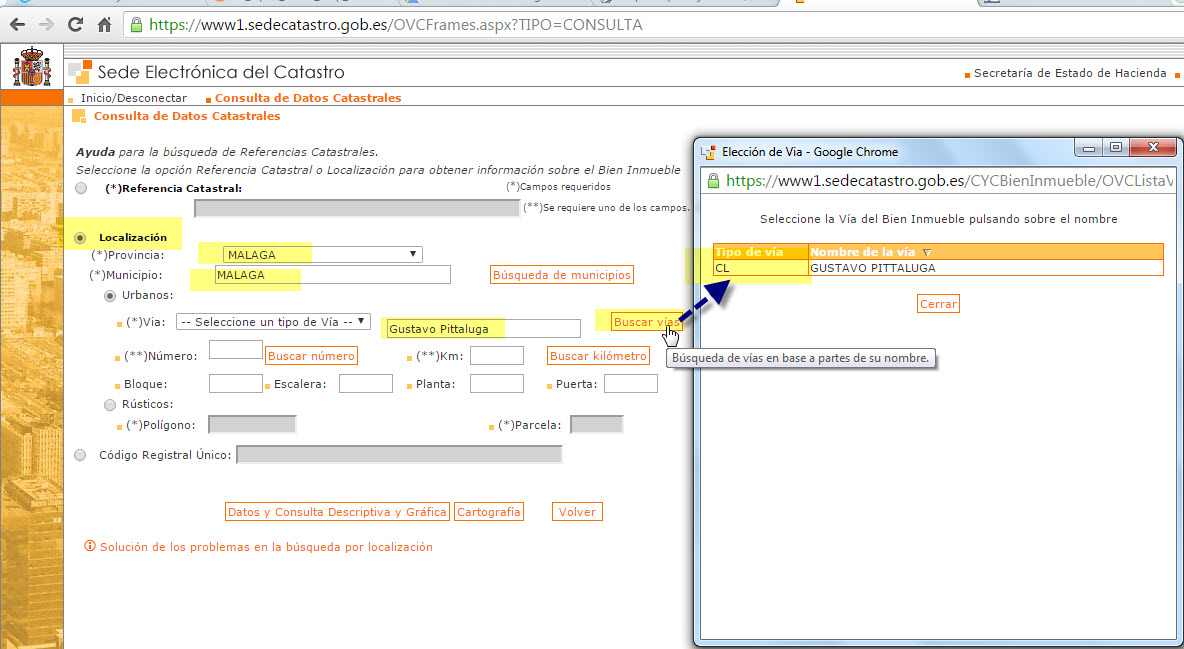

In [30]:
Image("improvement_openstreetmap.jpg")

<body> 
Resources:

https://github.com/bestkao/data-wrangling-with-openstreetmap-and-mongodb

https://github.com/lyvinhhung/Udacity-Data-Analyst-Nanodegree/blob/master/p3%20-%20Wrangle%20OpenStreetMap%20Data/P3%20-%20Data%20Wrangling%20with%20MongoDB.ipynb
<body>